In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append('..')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
import shap

# Feature Engineering

Read in the Rossman Kaggle data. Do some lightweight feature engineering. In this simplified version of the problem, the point is to predict the sales on a particular day. In the real problem the task is to predict the next 30 days of sales on any given day. 

In [3]:
train_df = pd.read_csv('../data/kaggle_train.csv')
test_df = pd.read_csv('../data/kaggle_test.csv')
store_df = pd.read_csv('../data/kaggle_store.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Features
train_df['dt'] = pd.to_datetime(train_df['Date'])
train_df['MonthOfYear'] = train_df['dt'].map(lambda x: x.month)
zz = pd.get_dummies(train_df['StateHoliday'], prefix='state_holiday')
state_holiday = zz[['state_holiday_a', 'state_holiday_b', 'state_holiday_c']]
aug_train_df = pd.merge(train_df, state_holiday, how='inner', left_index=True, right_index=True)

In [5]:
# Feature selection
X = aug_train_df[['DayOfWeek', 'MonthOfYear', 'Open', 'Promo', 'SchoolHoliday', 
                  'state_holiday_a', 'state_holiday_b', 'state_holiday_c']]
# Target Variable
y = aug_train_df['Sales']

In [6]:
X.head()

,DayOfWeek,MonthOfYear,Open,Promo,SchoolHoliday,state_holiday_a,state_holiday_b,state_holiday_c
0,5,7,1,1,1,0,0,0
1,5,7,1,1,1,0,0,0
2,5,7,1,1,1,0,0,0
3,5,7,1,1,1,0,0,0
4,5,7,1,1,1,0,0,0


In [7]:
X.describe()

,DayOfWeek,MonthOfYear,Open,Promo,SchoolHoliday,state_holiday_a,state_holiday_b,state_holiday_c
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,3.998341e+00,5.846762e+00,8.301067e-01,3.815145e-01,1.786467e-01,1.991724e-02,6.576820e-03,4.030637e-03
std,1.997391e+00,3.326097e+00,3.755392e-01,4.857586e-01,3.830564e-01,1.397160e-01,8.083051e-02,6.335925e-02
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.000000e+00,6.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,6.000000e+00,8.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,7.000000e+00,1.200000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [8]:
y.head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

# Modelling

We will build a random forest model.

In [10]:
rf = RandomForestRegressor(n_jobs=-1)
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

# SHAP Feature Importance

Lets run the SHAP Tree Explainer on all of these trained models and see what comes out. First lets do it on the random forest -- note that takes some time to run because it's doing all this crazy marginalization in all the trees. And this dataset has over 1M data points in it. 

In [11]:
shap.initjs()

In [12]:
rf_shap_values = shap.TreeExplainer(rf).shap_values(X)

In [13]:
def random_sample_shap_values(shap_values, X, y, num_samples=1000):
    random_indexes = np.random.choice(np.arange(0, len(shap_values)), num_samples)
    sampled_shap_values = shap_values[random_indexes, :]
    sampled_X = X.iloc[random_indexes, :]
    sampled_y = y.iloc[random_indexes]
    return sampled_shap_values, sampled_X, sampled_y

In [14]:
sampled_shap_values, sampled_X, sampled_y = random_sample_shap_values(rf_shap_values, X, y)

## Shap Summary Plot

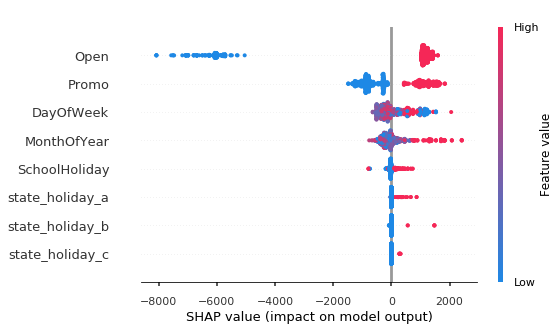

In [15]:
shap.summary_plot(sampled_shap_values, sampled_X, plot_type='dot')

## Classic Feature Importance Plot

Note that I need to do a PR into shap to put this in there as a standard.

In [16]:
sampled_X.shape

(1000, 8)

In [17]:
sampled_shap_values.shape

(1000, 9)

Note that there is one extra column to the shap value matrix. That is the base value -- the value that you would guess if you didn't know a value for any of the features. This should be the mean value for the dataset (right?). Ok, yes, it's close. Is it the mean value of y_hat? Not exactly that either. Where did this magical number come from? 

In [18]:
column_names = sampled_X.columns.values.tolist()
column_names.append('BaseValue')
shapley_df = pd.DataFrame(sampled_shap_values, columns=column_names)
shapley_df.head()

,DayOfWeek,MonthOfYear,Open,Promo,SchoolHoliday,state_holiday_a,state_holiday_b,state_holiday_c,BaseValue
0,-240.174919,-79.139105,1063.036688,-913.336434,-59.420728,-0.933287,-3.425299,-0.202899,5774.204629
1,214.773700,-348.262538,1083.492160,-1257.672055,-27.177126,-0.773142,-3.615490,-0.085390,5774.204629
2,-375.549426,-175.708852,1047.100909,-881.493812,-33.834082,-0.663427,-0.628144,-0.195878,5774.204629
3,984.413844,457.410621,-7065.695818,-136.352962,-12.915481,-0.411090,-0.591425,-0.062319,5774.204629
4,747.435385,-29.371745,-6260.888012,-218.795446,-14.067017,2.007262,-0.462737,-0.062319,5774.204629


In [19]:
y.mean()

5773.818972305593

In [20]:
y_hat = rf.predict(X)
y_hat.mean()

5775.380864505508

Text(0.5,0,'mean SHAP value magnitude')

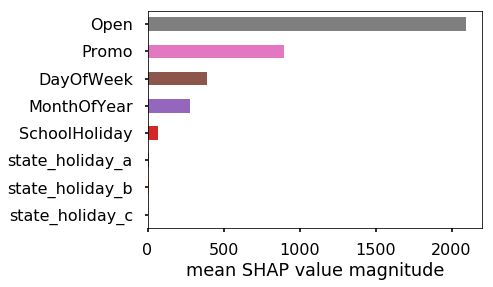

In [29]:
mean_abs_shap = np.abs(sampled_shap_values).mean(axis=0)[0:-1]
mean_abs_shap_df = pd.Series(mean_abs_shap, index=sampled_X.columns.values.tolist())
mean_abs_shap_df = mean_abs_shap_df.sort_values(ascending=True)
mean_abs_shap_df.plot(kind='barh')
plt.xlabel('mean SHAP value magnitude')

## Further Interpretation of Shap Values as Breakdown of the Estimate

In [22]:
index = 10
shap.force_plot(sampled_shap_values[index,:], sampled_X.iloc[index,:])

In [23]:
index = 0
shap.force_plot(sampled_shap_values[index,:], sampled_X.iloc[index,:])

In [24]:
shap.force_plot(sampled_shap_values, sampled_X)

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'y')

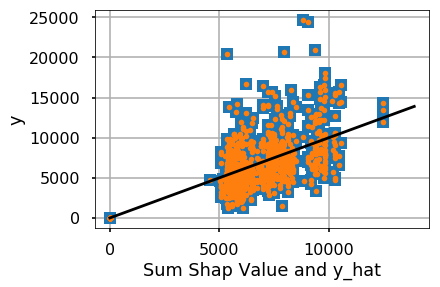

In [25]:
sum_shap = pd.Series(sampled_shap_values.sum(axis=1))
sampled_y_hat = rf.predict(sampled_X)
plt.plot(sampled_y_hat, sampled_y, 's')
plt.plot(sum_shap, sampled_y, '.')
plt.plot(range(0, 14000, 100), range(0, 14000, 100), 'k-')
plt.grid('on')
plt.xlabel('Sum Shap Value and y_hat')
plt.ylabel('y')

## Shap Dependence Plots

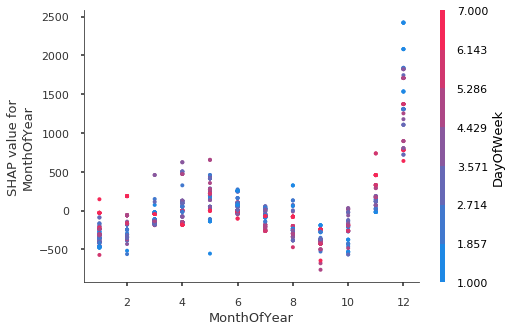

In [26]:
shap.dependence_plot('MonthOfYear', sampled_shap_values, sampled_X, interaction_index='DayOfWeek')

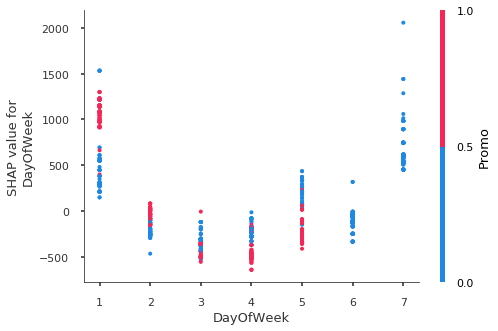

In [27]:
shap.dependence_plot('DayOfWeek', sampled_shap_values, sampled_X, interaction_index='Promo')

## Interaction Values

In [28]:
shap_interactions = shap.TreeExplainer(rf).shap_interaction_values(X)

Exception: Interaction values not yet supported for model type: internal